In [1]:
import numpy as np 
from Environment import Easy21
import matplotlib.pyplot as plt
from utils import *

<h2>Theoretical value function</h2>

In [2]:
##Action value
value_star = value_iteration(1000)

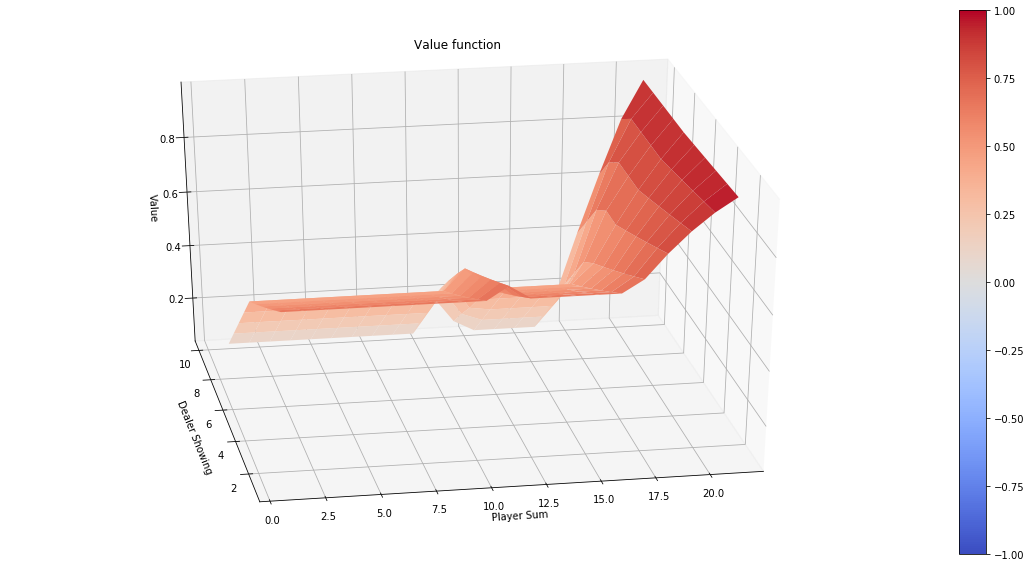

In [3]:
plot_value_function(value_star, degree= -100, cm = plt.cm.coolwarm)

<h2>Params</h2>

In [4]:
#Params
N0 = 100
discount_factor = 1


<h2>Monte-Carlo</h2>

In [5]:

##Monte Carlo
iterations_MC = int(1e7)
it_conf = int(1e4)
action_montecarlo, deltas, variance = montecarlo(iterations_MC, it_conf, N0, discount_factor, value_star)



Iteration n°0/10000000
Iteration n°10000/10000000
Iteration n°20000/10000000
Iteration n°30000/10000000
Iteration n°40000/10000000
Iteration n°50000/10000000
Iteration n°60000/10000000
Iteration n°70000/10000000
Iteration n°80000/10000000
Iteration n°90000/10000000
Iteration n°100000/10000000
Iteration n°110000/10000000
Iteration n°120000/10000000
Iteration n°130000/10000000
Iteration n°140000/10000000
Iteration n°150000/10000000
Iteration n°160000/10000000
Iteration n°170000/10000000
Iteration n°180000/10000000
Iteration n°190000/10000000
Iteration n°200000/10000000
Iteration n°210000/10000000
Iteration n°220000/10000000
Iteration n°230000/10000000
Iteration n°240000/10000000
Iteration n°250000/10000000
Iteration n°260000/10000000
Iteration n°270000/10000000
Iteration n°280000/10000000
Iteration n°290000/10000000
Iteration n°300000/10000000
Iteration n°310000/10000000
Iteration n°320000/10000000
Iteration n°330000/10000000
Iteration n°340000/10000000
Iteration n°350000/10000000
Iterat

Iteration n°2870000/10000000
Iteration n°2880000/10000000
Iteration n°2890000/10000000
Iteration n°2900000/10000000
Iteration n°2910000/10000000
Iteration n°2920000/10000000
Iteration n°2930000/10000000
Iteration n°2940000/10000000
Iteration n°2950000/10000000
Iteration n°2960000/10000000
Iteration n°2970000/10000000
Iteration n°2980000/10000000
Iteration n°2990000/10000000
Iteration n°3000000/10000000
Iteration n°3010000/10000000
Iteration n°3020000/10000000
Iteration n°3030000/10000000
Iteration n°3040000/10000000
Iteration n°3050000/10000000
Iteration n°3060000/10000000
Iteration n°3070000/10000000
Iteration n°3080000/10000000
Iteration n°3090000/10000000
Iteration n°3100000/10000000
Iteration n°3110000/10000000
Iteration n°3120000/10000000
Iteration n°3130000/10000000
Iteration n°3140000/10000000
Iteration n°3150000/10000000
Iteration n°3160000/10000000
Iteration n°3170000/10000000
Iteration n°3180000/10000000
Iteration n°3190000/10000000
Iteration n°3200000/10000000
Iteration n°32

Iteration n°5700000/10000000
Iteration n°5710000/10000000
Iteration n°5720000/10000000
Iteration n°5730000/10000000
Iteration n°5740000/10000000
Iteration n°5750000/10000000
Iteration n°5760000/10000000
Iteration n°5770000/10000000
Iteration n°5780000/10000000
Iteration n°5790000/10000000
Iteration n°5800000/10000000
Iteration n°5810000/10000000
Iteration n°5820000/10000000
Iteration n°5830000/10000000
Iteration n°5840000/10000000
Iteration n°5850000/10000000
Iteration n°5860000/10000000
Iteration n°5870000/10000000
Iteration n°5880000/10000000
Iteration n°5890000/10000000
Iteration n°5900000/10000000
Iteration n°5910000/10000000
Iteration n°5920000/10000000
Iteration n°5930000/10000000
Iteration n°5940000/10000000
Iteration n°5950000/10000000
Iteration n°5960000/10000000
Iteration n°5970000/10000000
Iteration n°5980000/10000000
Iteration n°5990000/10000000
Iteration n°6000000/10000000
Iteration n°6010000/10000000
Iteration n°6020000/10000000
Iteration n°6030000/10000000
Iteration n°60

Iteration n°8530000/10000000
Iteration n°8540000/10000000
Iteration n°8550000/10000000
Iteration n°8560000/10000000
Iteration n°8570000/10000000
Iteration n°8580000/10000000
Iteration n°8590000/10000000
Iteration n°8600000/10000000
Iteration n°8610000/10000000
Iteration n°8620000/10000000
Iteration n°8630000/10000000
Iteration n°8640000/10000000
Iteration n°8650000/10000000
Iteration n°8660000/10000000
Iteration n°8670000/10000000
Iteration n°8680000/10000000
Iteration n°8690000/10000000
Iteration n°8700000/10000000
Iteration n°8710000/10000000
Iteration n°8720000/10000000
Iteration n°8730000/10000000
Iteration n°8740000/10000000
Iteration n°8750000/10000000
Iteration n°8760000/10000000
Iteration n°8770000/10000000
Iteration n°8780000/10000000
Iteration n°8790000/10000000
Iteration n°8800000/10000000
Iteration n°8810000/10000000
Iteration n°8820000/10000000
Iteration n°8830000/10000000
Iteration n°8840000/10000000
Iteration n°8850000/10000000
Iteration n°8860000/10000000
Iteration n°88

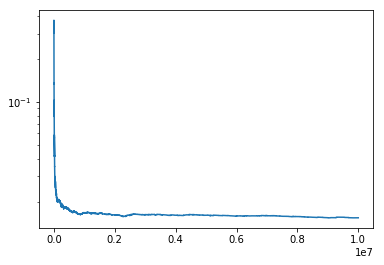

In [10]:
##MSE
plt.clf()
plt.plot([i for i in range(iterations_MC)], deltas)
plt.yscale("log")
plt.show()

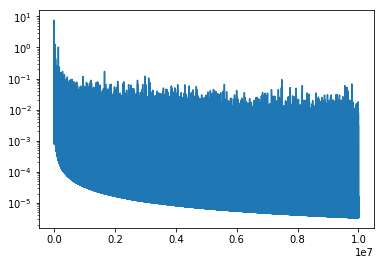

In [11]:
##Variance
plt.clf()
plt.plot([i for i in range(iterations_MC)], variance)
plt.yscale("log")
plt.show()

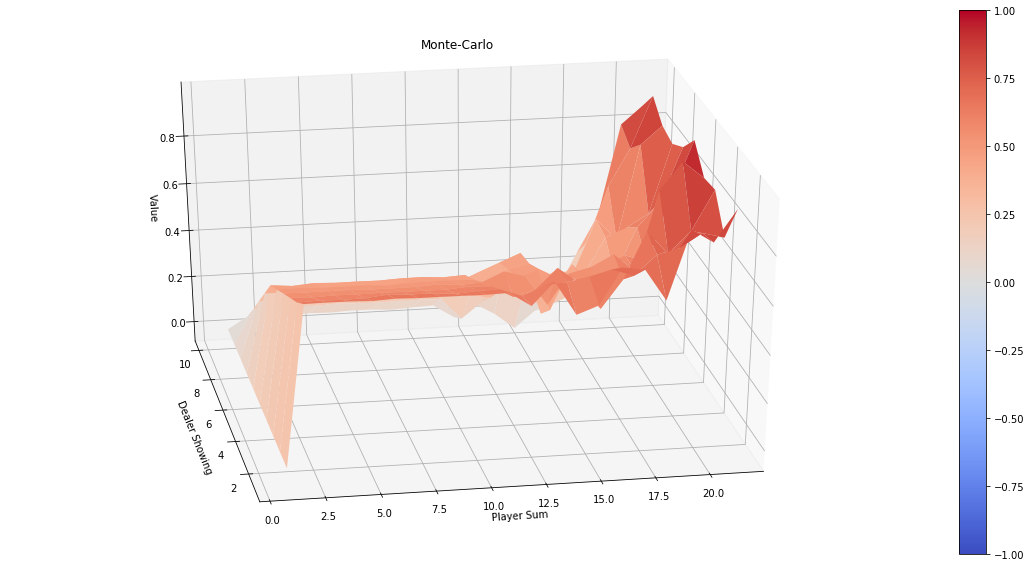

In [12]:
plt.clf() 
plot_value_function(get_value(action_montecarlo), degree= -100, title = "Monte-Carlo", cm = plt.cm.coolwarm)


In [14]:
action_montecarlo


array([[[ 0.00000000e+00,  0.00000000e+00],
        [-2.66479534e-01,  6.70116976e-01],
        [-1.16124517e-01,  6.71154328e-01],
        [-9.11356451e-02,  6.70536850e-01],
        [-3.20570426e-02,  6.67356160e-01],
        [ 1.14038040e-01,  6.71698758e-01],
        [ 1.10400854e-01,  6.69100488e-01],
        [ 2.69174066e-01,  6.68927571e-01],
        [ 2.13142889e-01,  6.68296096e-01],
        [ 3.08918550e-01,  6.67802028e-01],
        [ 3.68436278e-01,  6.69916742e-01],
        [ 4.63377119e-01,  6.12334802e-01],
        [ 3.86741480e-01,  7.05069124e-01],
        [ 2.29032258e-01,  5.67010309e-01],
        [ 9.17035210e-02,  6.00000000e-01],
        [ 1.02769434e-01,  7.46666667e-01],
        [ 1.96078431e-02,  7.33333333e-01],
        [-1.56143645e-01,  6.04651163e-01],
        [-2.10298209e-02,  8.81355932e-01],
        [-2.16216216e-01,  8.26923077e-01],
        [-4.14933650e-01,  9.54545455e-01],
        [-1.62790698e-01,  1.00000000e+00]],

       [[ 0.00000000e+00,  0.0

<h2>TD Lambda</h2>

<h3>Comparing performance for different lambdas</h3>

In [ ]:
def td_lambda_backward_view2(iterations, N0, discount_factor, Lambda, value_star):
    MSEs = []
    actions = ["Hit", "Stick"]
    action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    number_action_value = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
    eligibility_traces = None 

    for it in range(iterations):
        
        """plays one episode"""
        eligibility_traces = np.array([[[0.0,0.0] for i in range(0,22)] for j in range(10)])
        game = Easy21()
        visits = []
        ##Action chosen epsilon-greedily
        first_state = game.state
        index_action = policy_epsilon_greedy(N0, first_state["dealer"], first_state["player_sum"], action_value, number_action_value)
        """plays game epsilon-greedily"""
        while game.isTerminal == False:
            
            last_state = game.state
            dealer, player_sum = last_state["dealer"], last_state["player_sum"]
            
           
            
            pick_action = actions[index_action]
            number_action_value[dealer-1, player_sum, index_action]+=1
            alpha = 1/number_action_value[dealer-1, player_sum, index_action]
            
            _,reward = game.step(pick_action)
            eligibility_traces[dealer-1, player_sum, index_action]+=1

            if game.isTerminal == False:
                next_state = game.state
                next_dealer , next_player_sum = next_state["dealer"], next_state["player_sum"]
                next_index_action = policy_epsilon_greedy(N0, next_dealer, next_player_sum, action_value, number_action_value)
                target = reward + discount_factor * action_value[next_dealer-1, next_player_sum, next_index_action]
                index_action = next_index_action

            else: 
                target = reward
            delta = target - action_value[dealer-1, player_sum, index_action]
            delta_tot = eligibility_traces * delta  * alpha
            ##We update all states and actions
            action_value += delta_tot
             
            eligibility_traces = discount_factor * Lambda * eligibility_traces
        """episode ended"""
       
        error_episode = np.linalg.norm(get_value(action_value)-value_star)**2 / (2 * 22 * 10)
        MSEs.append(error_episode)
    return MSEs, action_value

In [9]:
##TD
iterations = int(2e4)
lambdas = [i/10 for i in range(11)]
MSEs_all = []
plt.clf()
for i in range(len(lambdas)):
    MSEs,action_value= td_lambda_backward_view(iterations, N0, discount_factor, lambdas[i], value_star)
    MSEs_all.append(MSEs)
episodes = [i for i in range(iterations)]

for k in range(len(lambdas)):
    plt.plot(episodes, MSEs_all[k])
    
plt.xlabel("Episode n°")
plt.ylabel("MSE")
plt.legend(["lambda = " + str(Lambda) for Lambda in lambdas])
plt.title("MSE of error VS Q* against episode number")

plt.show()

NameError: name 'td_lambda_backward_view2' is not defined

<h3>Plot value function for a specific lambda</h3>

In [ ]:
lambda1 = 0.5
discount_factor= 1.0
iterations = int(1e5)

plt.clf()
MSEs, av = td_lambda_backward_view2(iterations, N0, discount_factor, lambda1, value_star)
plt.plot([i for i in range(iterations)], MSEs)
plt.show()

In [ ]:
plt.clf()
plot_value_function(get_value(av), degree= -100, cm = plt.cm.coolwarm)

In [ ]:
plot_value_function(value_star, degree= -100, cm = plt.cm.coolwarm)